In [1]:
from rdflib import Graph 
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.schema import Document
from sklearn.cluster import KMeans
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import numpy as np
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# Load the graph
g = Graph()
g.parse("data/dunbar/bacnet.ttl", format="turtle")

<Graph identifier=N4ed3ea0a589e48349bbfb057c968816a (<class 'rdflib.graph.Graph'>)>

In [3]:
# Bacnet Devices

# Create the documents to load into the vector store
documents = []

# Define a SPARQL query for bacnet_Device
query_for_devices = """
PREFIX bacnet: <http://data.ashrae.org/bacnet/2016#>

SELECT ?device_name
WHERE {
  ?device a bacnet:bacnet_Device ;
          bacnet:device_name ?device_name .
}
"""

# Run the query for devices
for row in g.query(query_for_devices):
    device_name = row[0]

    # Create the document
    content = device_name.value
    documents.append(Document(page_content=content, metadata={"type": "bacnet_device"}))

In [6]:
# Bacnet Points

# Create the documents to load into the vector store
documents = []

# Define a SPARQL query for bacnet_Point
query_for_points = """
PREFIX bacnet: <http://data.ashrae.org/bacnet/2016#>

SELECT ?device_name ?point_name ?present_value ?unit
WHERE {
  ?point a bacnet:bacnet_Point ;
         bacnet:device_name ?device_name ;
         bacnet:object_name ?point_name ;
         bacnet:present_value ?present_value ;
         bacnet:object_units ?unit .
}
"""

# Run the query for points
for row in g.query(query_for_points):
    device_name, point_name, present_value, unit = row
    
    content = point_name.value + " " + present_value.value + " " + unit.value
    documents.append(Document(page_content=content, metadata={"type": "bacnet_point"}))

In [4]:
# Load the documents into the vector store
db = Chroma.from_documents(documents, OpenAIEmbeddings())

In [5]:
vectorstore_data = db.get(include=["embeddings", "metadatas"])
embs = vectorstore_data["embeddings"]
embs = np.vstack(embs)
embs.shape

(354, 1536)

 10%|█         | 10/99 [00:03<00:35,  2.52it/s]


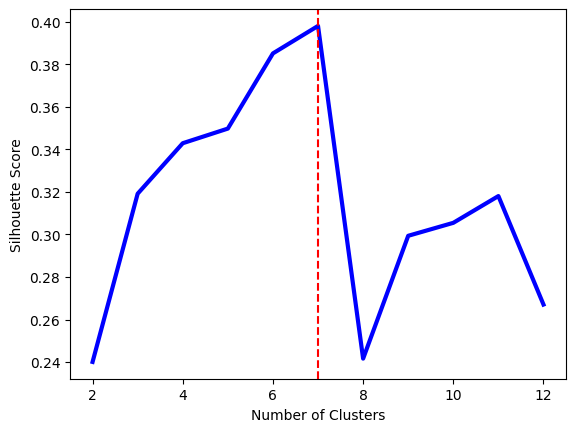

Optimal number of clusters: 7


In [15]:
sil = [] # list of silhouette scores
kmin, kmax = 2, 100
patience = 5  # number of iterations to continue after score decreases
counter = 0  # counter for number of iterations since score decreased
best_score = -1  # initialize with worst possible silhouette score

for k in tqdm(range(kmin, kmax+1)):
    kmeans = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=0, batch_size=1000).fit(embs) # adjust batch_size as needed
    labels = kmeans.labels_
    score = silhouette_score(embs, labels, metric='euclidean')
    sil.append(score)

    # Early stopping with patience
    if score > best_score:
        best_score = score
        counter = 0  # reset counter when score improves
    else:
        counter += 1  # increment counter when score does not improve
        if counter >= patience:
            break

optimal_clusters = np.argmax(sil) + kmin  # +kmin because the range starts from kmin

# Plot silhouette scores
plt.plot(range(kmin, len(sil)+kmin), sil, color='blue', linewidth='3')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.axvline(x=optimal_clusters, color='red', linestyle='--')
plt.show()
print("Optimal number of clusters:", optimal_clusters)

In [27]:
# Perform k-means clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
cluster_assignments = kmeans.fit_predict(embs)
labels = kmeans.labels_

/Users/anthonydemattos/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


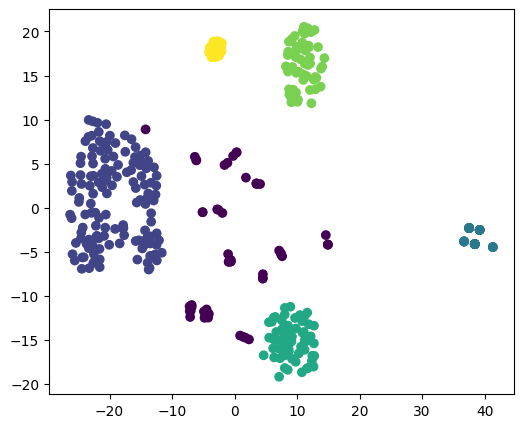

In [10]:
# Plot the clusters
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Convert list to numpy array
embs_array = np.array(embs)

tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(embs_array)

plt.figure(figsize=(6, 5))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_assignments)
plt.show()

In [11]:
# Create a dictionary of clusters, with the key being the cluster number and the value being the list of documents in that cluster
cluster_dict = {}
for i in range(len(labels)):
    cluster_dict.setdefault(labels[i], []).append(documents[i])

# Print the clusters
for cluster in cluster_dict:
    print("Cluster", cluster)
    for document in cluster_dict[cluster]:
        print(document.metadata["type"], document.page_content)
    print()

Cluster 0
bacnet_device Engineering
bacnet_device Engineering
bacnet_device Engineering
bacnet_device BTU METER 1020
bacnet_device BTU METER 1021
bacnet_device BTU METER 1022
bacnet_device AHU-3 AFMS
bacnet_device ATV212
bacnet_device CHILLED/COND WATER
bacnet_device MTIIChillerUC100001
bacnet_device pCOWeb88004
bacnet_device enteliBUS Manager 4104766
bacnet_device MTIIChillerUC200002
bacnet_device Volttron BACnet driver
bacnet_device HOT WATER PLANT
bacnet_device 
bacnet_device A-WING FLRS 3&4 DOAS2
bacnet_device Device_0030de05fef2
bacnet_device B-WING VAVS
bacnet_device AHU1
bacnet_device AHU2
bacnet_device AHU3
bacnet_device AHU5
bacnet_device AHU6
bacnet_device AHU7
bacnet_device C-WING RTU DOAS1&6
bacnet_device A-WING FLOORS 1&2
bacnet_device AHU-1 AFMS
bacnet_device BTU METER 2020
bacnet_device ATV212
bacnet_device EF-18
bacnet_device FCU-11&12 1ST FLR
bacnet_device FCU-14&15 2ND FLR
bacnet_device GARAGE EXHAUST
bacnet_device AHU-7 AFMS
bacnet_device ATV212
bacnet_device ATV212_

In [12]:
from openai import OpenAI
client = OpenAI()

In [21]:
device_names = []
for document in cluster_dict[0]:
    device_names.append(document.page_content)

names = "\n".join(device_names)
names

'Engineering\nEngineering\nEngineering\nBTU METER 1020\nBTU METER 1021\nBTU METER 1022\nAHU-3 AFMS\nATV212\nCHILLED/COND WATER\nMTIIChillerUC100001\npCOWeb88004\nenteliBUS Manager 4104766\nMTIIChillerUC200002\nVolttron BACnet driver\nHOT WATER PLANT\n\nA-WING FLRS 3&4 DOAS2\nDevice_0030de05fef2\nB-WING VAVS\nAHU1\nAHU2\nAHU3\nAHU5\nAHU6\nAHU7\nC-WING RTU DOAS1&6\nA-WING FLOORS 1&2\nAHU-1 AFMS\nBTU METER 2020\nATV212\nEF-18\nFCU-11&12 1ST FLR\nFCU-14&15 2ND FLR\nGARAGE EXHAUST\nAHU-7 AFMS\nATV212\nATV212_005\nEF-17\nEF-23\nFCU-13\npCOnet77001\nATV212\nAHU-5 AFMS\nAHU-2 AFMS\nATV212\nAHU-6 AFMS\nAHU-4 AFMS\nWATT_BACnet\nWATT_BACnet_66005\npCOnet77006\nDHW\nEF-5&9\nDev_MSTP'

In [25]:
db.similarity_search("AHU", k=10, filter={"type": "bacnet_device"})

[Document(page_content='AHU1', metadata={'type': 'bacnet_device'}),
 Document(page_content='AHU3', metadata={'type': 'bacnet_device'}),
 Document(page_content='AHU5', metadata={'type': 'bacnet_device'}),
 Document(page_content='AHU6', metadata={'type': 'bacnet_device'}),
 Document(page_content='AHU7', metadata={'type': 'bacnet_device'}),
 Document(page_content='AHU2', metadata={'type': 'bacnet_device'}),
 Document(page_content='AHU-1 AFMS', metadata={'type': 'bacnet_device'}),
 Document(page_content='AHU-5 AFMS', metadata={'type': 'bacnet_device'}),
 Document(page_content='AHU-2 AFMS', metadata={'type': 'bacnet_device'}),
 Document(page_content='AHU-6 AFMS', metadata={'type': 'bacnet_device'})]